In [1]:
import os
os.environ['KERAS_BACKEND']='tensorflow' # 也可以使用 tensorflow
#os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,exception_verbosity=high'
os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_compile'

modifed from https://github.com/martinarjovsky/WassersteinGAN 

In [2]:
import keras.backend as K
K.set_image_data_format('channels_first')
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal
conv_init = RandomNormal(0, 0.02)
gamma_init = RandomNormal(1., 0.02)


Using TensorFlow backend.


In [3]:
def DCGAN_D(isize, nz, nc, ndf, n_extra_layers=0):
    assert isize%2==0
    _ = inputs = Input(shape=(nc, isize, isize))
    _ = Conv2D(filters=ndf, kernel_size=4, strides=2, use_bias=False,
                        padding = "same",
                        kernel_initializer = conv_init, 
                        name = 'initial.conv.{0}-{1}'.format(nc, ndf)             
                        ) (_)
    _ = LeakyReLU(alpha=0.2, name = 'initial.relu.{0}'.format(ndf))(_)
    csize, cndf = isize// 2, ndf
    while csize > 5:
        assert csize%2==0
        in_feat = cndf
        out_feat = cndf*2
        _ = Conv2D(filters=out_feat, kernel_size=4, strides=2, use_bias=False,
                        padding = "same",
                        kernel_initializer = conv_init,
                        name = 'pyramid.{0}-{1}.conv'.format(in_feat, out_feat)             
                        ) (_)
        if 0: # toggle batchnormalization
            _ = BatchNormalization(name = 'pyramid.{0}.batchnorm'.format(out_feat),                                   
                                   momentum=0.9, axis=1, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init, 
                                  )(_, training=1)        
        _ = LeakyReLU(alpha=0.2, name = 'pyramid.{0}.relu'.format(out_feat))(_)
        csize, cndf = (csize+1)//2, cndf*2
    _ = Conv2D(filters=1, kernel_size=csize, strides=1, use_bias=False,
                        kernel_initializer = conv_init,
                        name = 'final.{0}-{1}.conv'.format(cndf, 1)         
                        ) (_)
    outputs = Flatten()(_)
    return Model(inputs=inputs, outputs=outputs)


In [4]:
def DCGAN_G(isize, nz, nc, ngf, n_extra_layers=0):
    cngf= ngf//2
    tisize = isize
    while tisize > 5:
        cngf = cngf * 2
        assert tisize%2==0
        tisize = tisize // 2
    _ = inputs = Input(shape=(nz,))
    _ = Reshape((nz, 1,1))(_)
    _ = Conv2DTranspose(filters=cngf, kernel_size=tisize, strides=1, use_bias=False,
                           kernel_initializer = conv_init, 
                           name = 'initial.{0}-{1}.convt'.format(nz, cngf))(_)
    _ = BatchNormalization(gamma_initializer = gamma_init, momentum=0.9, axis=1, epsilon=1.01e-5,
                               name = 'initial.{0}.batchnorm'.format(cngf))(_, training=1)
    _ = Activation("relu", name = 'initial.{0}.relu'.format(cngf))(_)
    csize, cndf = tisize, cngf
    

    while csize < isize//2:
        in_feat = cngf
        out_feat = cngf//2
        _ = Conv2DTranspose(filters=out_feat, kernel_size=4, strides=2, use_bias=False,
                        kernel_initializer = conv_init, padding="same",
                        name = 'pyramid.{0}-{1}.convt'.format(in_feat, out_feat)             
                        ) (_)
        _ = BatchNormalization(gamma_initializer = gamma_init, 
                                   momentum=0.9, axis=1, epsilon=1.01e-5,
                                   name = 'pyramid.{0}.batchnorm'.format(out_feat))(_, training=1)
        
        _ = Activation("relu", name = 'pyramid.{0}.relu'.format(out_feat))(_)
        csize, cngf = csize*2, cngf//2
    _ = Conv2DTranspose(filters=nc, kernel_size=4, strides=2, use_bias=False,
                        kernel_initializer = conv_init, padding="same",
                        name = 'final.{0}-{1}.convt'.format(cngf, nc)
                        )(_)
    outputs = Activation("tanh", name = 'final.{0}.tanh'.format(nc))(_)
    return Model(inputs=inputs, outputs=outputs)


Parameters

In [5]:
nc = 3
nz = 100
ngf = 64
ndf = 64
n_extra_layers = 0
Diters = 5
λ = 10

imageSize = 32
batchSize = 64
lrD = 1e-4
lrG = 1e-4


print models

In [6]:
netD = DCGAN_D(imageSize, nz, nc, ndf, n_extra_layers)
netD.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 32, 32)         0         
_________________________________________________________________
initial.conv.3-64 (Conv2D)   (None, 64, 16, 16)        3072      
_________________________________________________________________
initial.relu.64 (LeakyReLU)  (None, 64, 16, 16)        0         
_________________________________________________________________
pyramid.64-128.conv (Conv2D) (None, 128, 8, 8)         131072    
_________________________________________________________________
pyramid.128.relu (LeakyReLU) (None, 128, 8, 8)         0         
_________________________________________________________________
pyramid.128-256.conv (Conv2D (None, 256, 4, 4)         524288    
_________________________________________________________________
pyramid.256.relu (LeakyReLU) (None, 256, 4, 4)         0         
__________

In [7]:
netG = DCGAN_G(imageSize, nz, nc, ngf, n_extra_layers)
netG.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 100, 1, 1)         0         
_________________________________________________________________
initial.100-256.convt (Conv2 (None, 256, 4, 4)         409600    
_________________________________________________________________
initial.256.batchnorm (Batch (None, 256, 4, 4)         1024      
_________________________________________________________________
initial.256.relu (Activation (None, 256, 4, 4)         0         
_________________________________________________________________
pyramid.256-128.convt (Conv2 (None, 128, 8, 8)         524288    
_________________________________________________________________
pyramid.128.batchnorm (Batch (None, 128, 8, 8)         512       
__________

In [8]:
from keras.optimizers import RMSprop, SGD, Adam

compute Wasserstein loss and  gradient penalty

In [9]:
netD_real_input = Input(shape=(nc, imageSize, imageSize))
noisev = Input(shape=(nz,))
netD_fake_input = netG(noisev)

ϵ_input = K.placeholder(shape=(None,1,1,1))
netD_mixed_input = Input(shape=(nc, imageSize, imageSize),
    tensor=ϵ_input * netD_real_input + (1-ϵ_input) * netD_fake_input)


loss_real = K.mean(netD(netD_real_input))
loss_fake = K.mean(netD(netD_fake_input))

grad_mixed = K.gradients(netD(netD_mixed_input), [netD_mixed_input])[0]
norm_grad_mixed = K.sqrt(K.sum(K.square(grad_mixed), axis=[1,2,3]))
grad_penalty = K.mean(K.square(norm_grad_mixed -1))

loss = loss_fake - loss_real + λ * grad_penalty


training_updates = Adam(lr=lrD, beta_1=0.0, beta_2=0.9).get_updates(netD.trainable_weights,[],loss)
netD_train = K.function([netD_real_input, noisev, ϵ_input],
                        [loss_real, loss_fake],    
                        training_updates)

loss for netG

In [10]:
loss = -loss_fake 
training_updates = Adam(lr=lrG, beta_1=0.0, beta_2=0.9).get_updates(netG.trainable_weights,[], loss)
netG_train = K.function([noisev], [loss], training_updates)


Download CIFAR10 if needed

In [11]:
from PIL import Image
import numpy as np
import tarfile

# Download dataset
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
import os
import urllib
from urllib.request import urlretrieve
def reporthook(a,b,c):
    print("\rdownloading: %5.1f%%"%(a*b*100.0/c), end="")
tar_gz = "cifar-10-python.tar.gz"
if not os.path.isfile(tar_gz):
        print('Downloading data from %s' % url)
        urlretrieve(url, tar_gz, reporthook=reporthook)

import pickle
train_X=[]
train_y=[]
tar_gz = "cifar-10-python.tar.gz"
with tarfile.open(tar_gz) as tarf:
    for i in range(1, 6):
        dataset = "cifar-10-batches-py/data_batch_%d"%i
        print("load",dataset)
        with tarf.extractfile(dataset) as f:
            result = pickle.load(f, encoding='latin1')
        train_X.extend( result['data'].reshape(-1,3,32,32)/255*2-1)
        train_y.extend(result['labels'])
    train_X=np.float32(train_X)
    train_y=np.int32(train_y)
    dataset = "cifar-10-batches-py/test_batch"
    print("load",dataset)
    with tarf.extractfile(dataset) as f:
        result = pickle.load(f, encoding='latin1')
        test_X=np.float32(result['data'].reshape(-1,3,32,32)/255*2-1)
        test_y=np.int32(result['labels'])
        

load cifar-10-batches-py/data_batch_1
load cifar-10-batches-py/data_batch_2
load cifar-10-batches-py/data_batch_3
load cifar-10-batches-py/data_batch_4
load cifar-10-batches-py/data_batch_5
load cifar-10-batches-py/test_batch


also using test_X

In [12]:
train_X = np.concatenate([train_X, test_X])
train_X = np.concatenate([train_X[:,:,:,::-1], train_X])

utility to show images

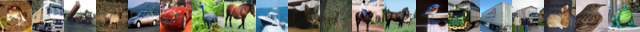

[6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6]
['frog' 'truck' 'truck' 'deer' 'car' 'car' 'bird' 'horse' 'boat' 'cat'
 'deer' 'horse' 'horse' 'bird' 'truck' 'truck' 'truck' 'cat' 'bird' 'frog']


In [13]:
from IPython.display import display
def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    # N*3072 -> N*3*32*32 -> 32 * 32N * 3
    int_X = np.moveaxis(int_X.reshape(-1,3,32,32), 1, 3)
    int_X = int_X.reshape(rows, -1, 32, 32,3).swapaxes(1,2).reshape(rows*32,-1, 3)
    display(Image.fromarray(int_X))
# 訓練資料， X 的前 20 筆
showX(train_X[:20])
print(train_y[:20])
name_array = np.array("airplane car bird cat deer dog frog horse boat truck".split(' '))
print(name_array[train_y[:20]])

In [14]:
fixed_noise = np.random.normal(size=(batchSize, nz)).astype('float32')

[0/100][100/1875][0] Loss_D: 45.709274 Loss_G: 0.000000 Loss_D_real: 44.376972 Loss_D_fake -1.332301 4.3198559284210205


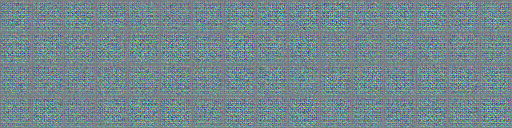

[2/100][1200/1875][500] Loss_D: 8.584233 Loss_G: 2.998339 Loss_D_real: 5.212162 Loss_D_fake -3.372072 160.86871147155762


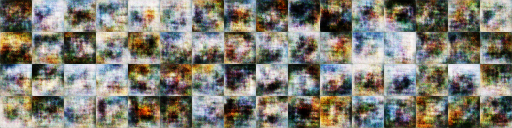

[3/100][1875/1875][1000] Loss_D: 4.872338 Loss_G: -0.354863 Loss_D_real: 3.093203 Loss_D_fake -1.779135 248.53403735160828


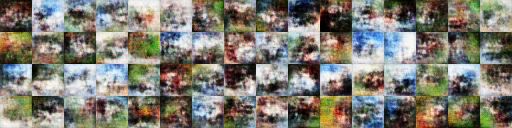

[5/100][720/1875][1500] Loss_D: 4.945425 Loss_G: 2.147443 Loss_D_real: 1.286394 Loss_D_fake -3.659031 337.87301230430603


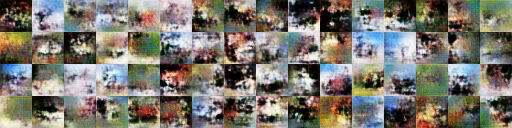

[6/100][1440/1875][2000] Loss_D: 3.854724 Loss_G: -2.091575 Loss_D_real: 4.120568 Loss_D_fake 0.265844 427.10607862472534


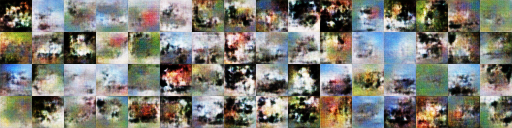

[8/100][285/1875][2500] Loss_D: 4.105051 Loss_G: -0.268429 Loss_D_real: -1.573398 Loss_D_fake -5.678449 516.8585650920868


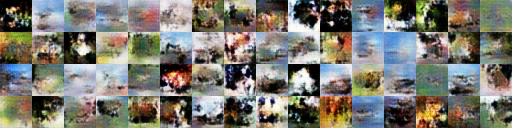

[9/100][1005/1875][3000] Loss_D: 4.892786 Loss_G: -1.576915 Loss_D_real: 3.678064 Loss_D_fake -1.214721 606.1206977367401


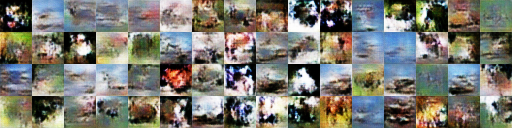

[10/100][1725/1875][3500] Loss_D: 3.300611 Loss_G: 1.440212 Loss_D_real: 0.887677 Loss_D_fake -2.412933 695.4318635463715


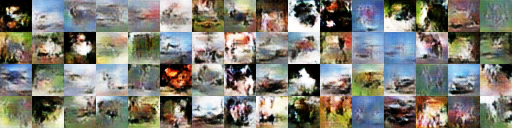

KeyboardInterrupt: 

In [15]:
import time
t0 = time.time()
niter = 100
gen_iterations = 0
errG = 0
targetD = np.float32([2]*batchSize+[-2]*batchSize)[:, None]
targetG = np.ones(batchSize, dtype=np.float32)[:, None]
for epoch in range(niter):
    i = 0
    #  每個 epoch 洗牌一下
    np.random.shuffle(train_X)
    batches = train_X.shape[0]//batchSize
    while i < batches:
        if gen_iterations < 25 or gen_iterations % 500 == 0:
            _Diters = 100
        else:
            _Diters = Diters
        j = 0
        while j < _Diters and i < batches:
            j+=1
            real_data = train_X[i*batchSize:(i+1)*batchSize]
            i+=1
            noise = np.random.normal(size=(batchSize, nz))        
            ϵ = np.random.uniform(size=(batchSize, 1, 1 ,1))        
            errD_real, errD_fake  = netD_train([real_data, noise, ϵ])
            errD = errD_real - errD_fake
       
        if gen_iterations%500==0:
            print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f'
            % (epoch, niter, i, batches, gen_iterations,errD, errG, errD_real, errD_fake), time.time()-t0)
            fake = netG.predict(fixed_noise)
            showX(fake, 4)
        
        noise = np.random.normal(size=(batchSize, nz))        
        errG, = netG_train([noise])
        gen_iterations+=1 
        